Skintone Recognition Model 

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from imageio import imread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

Resizing the Faces

In [3]:
def resize_images(input_folder, output_folder, target_size):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        # Check if the file is an image (you can add more specific image formats if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            try:
                # Open the image file
                image_path = os.path.join(input_folder, filename)
                with Image.open(image_path) as img:
                    # Resize the image
                    resized_img = img.resize(target_size, Image.LANCZOS)

                    # Save the resized image to the output folder
                    output_path = os.path.join(output_folder, filename)
                    resized_img.save(output_path)
                    print(f"Resized and saved: {filename}")
            except Exception as e:
                print(f"Error resizing {filename}: {e}")

if __name__ == "__main__":
    # Set input and output folders and target size
    # input_folder = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces'
    # output_folder = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
    input_folder = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces\\mst_faces'
    output_folder = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
    
    target_size = (224, 224)  # Set the target size (width, height)

    # Resize images in the input folder and save to the output folder
    resize_images(input_folder, output_folder, target_size)

Resized and saved: 10_PXL_20220922_175138290.jpg
Resized and saved: 10_PXL_20220922_175140560.jpg
Resized and saved: 10_PXL_20220922_175142212.jpg
Resized and saved: 10_PXL_20220922_175145715.jpg
Resized and saved: 10_PXL_20220922_175149121.jpg
Resized and saved: 10_PXL_20220922_175151358.jpg
Resized and saved: 10_PXL_20220922_175152817.jpg
Resized and saved: 10_PXL_20220922_175154352.jpg
Resized and saved: 10_PXL_20220922_175155744.jpg
Resized and saved: 10_PXL_20220922_175157945.jpg
Resized and saved: 10_PXL_20220922_175159465.jpg
Resized and saved: 10_PXL_20220922_175201134.jpg
Resized and saved: 10_PXL_20220922_175203683.jpg
Resized and saved: 10_PXL_20220922_175205602.jpg
Resized and saved: 10_PXL_20220922_175210525.jpg
Resized and saved: 10_PXL_20220922_175212910.jpg
Resized and saved: 10_PXL_20220922_175213980.jpg
Resized and saved: 10_PXL_20220922_175216751.jpg
Resized and saved: 10_PXL_20220922_175218550.jpg
Resized and saved: 10_PXL_20220922_175222824.jpg
Resized and saved: 1

Loading Images to Array

In [4]:
def load_images_to_array(folder_path):
    image_list = []
    
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image (you can add more specific image formats if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            try:
                # Open the image file
                image_path = os.path.join(folder_path, filename)
                with Image.open(image_path) as img:
                    # Convert the image to a NumPy array
                    img_array = np.array(img)
                    
                    # Append the image array to the list
                    image_list.append(img_array)
                    print(f"Loaded: {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return image_list

if __name__ == "__main__":
    # Set the path to the folder containing images
    # folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
    folder_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
    
    # Load images from the folder into a list of NumPy arrays
    images_as_arrays = load_images_to_array(folder_path)
    
    #'images_as_arrays' contains NumPy arrays of all the images

Loaded: 10_PXL_20220922_175138290.jpg
Loaded: 10_PXL_20220922_175140560.jpg
Loaded: 10_PXL_20220922_175142212.jpg
Loaded: 10_PXL_20220922_175145715.jpg
Loaded: 10_PXL_20220922_175149121.jpg
Loaded: 10_PXL_20220922_175151358.jpg
Loaded: 10_PXL_20220922_175152817.jpg
Loaded: 10_PXL_20220922_175154352.jpg
Loaded: 10_PXL_20220922_175155744.jpg
Loaded: 10_PXL_20220922_175157945.jpg
Loaded: 10_PXL_20220922_175159465.jpg
Loaded: 10_PXL_20220922_175201134.jpg
Loaded: 10_PXL_20220922_175203683.jpg
Loaded: 10_PXL_20220922_175205602.jpg
Loaded: 10_PXL_20220922_175210525.jpg
Loaded: 10_PXL_20220922_175212910.jpg
Loaded: 10_PXL_20220922_175213980.jpg
Loaded: 10_PXL_20220922_175216751.jpg
Loaded: 10_PXL_20220922_175218550.jpg
Loaded: 10_PXL_20220922_175222824.jpg
Loaded: 10_PXL_20220922_175223698.jpg
Loaded: 10_PXL_20220922_175304753.jpg
Loaded: 10_PXL_20220922_175307113.jpg
Loaded: 10_PXL_20220922_175309582.jpg
Loaded: 10_PXL_20220922_175312693.jpg
Loaded: 10_PXL_20220922_175315326.jpg
Loaded: 10_P

Making Array of Labels

In [6]:
# Path to the folder containing images
# folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
folder_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'

# Initialize an empty list to store labels
labels = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you can add more specific image formats if needed)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        # Extracting the label from the image filename
        label = filename.split('_')[0]
        labels.append(label)

labels = np.array(labels, dtype=np.int32)

# To make output between the range 0-9
labels = labels - 1
# Printing the extracted labels
print(f"Length of labels array: {len(labels)}")
print("Extracted Labels:", labels)

Length of labels array: 1055
Extracted Labels: [9 9 9 ... 8 8 8]


Normalizing Picture Array

In [8]:
# normalizing the pictures array (0->255 converted to -1->1)

images_as_arrays_normalized = [preprocess_input(image) for image in images_as_arrays]
#Length of array (number of images)
print(f"length of image array: {len(images_as_arrays_normalized)}")

length of image array: 1055


In [9]:
#Assigning Variables for ease
# dataset_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
dataset_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
input_shape = (224, 224, 3)
classes = ['MST 1', 'MST 2', 'MST 3', 'MST 4', 'MST 5', 'MST 6', 'MST 7', 'MST 8', 'MST 9', 'MST 10']

epochs = 120  
batch_size = 32

Data splitting (Train and Test)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images_as_arrays_normalized, labels, test_size=0.2, random_state=69)

X_test = np.array(X_test)
X_train = np.array(X_train)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"X test Shape: {X_test.shape}")
print(f"y test Shape: {y_test.shape}\n")
print(f"X train Shape: {X_train.shape}")
print(f"y train Shape: {y_train.shape}")

X test Shape: (211, 224, 224, 3)
y test Shape: (211,)

X train Shape: (844, 224, 224, 3)
y train Shape: (844,)


In [11]:
base_model = MobileNetV2(input_shape=input_shape, 
                         include_top=False, 
                         weights='imagenet') #top layer exlcuded
base_model.trainable = False #Freezes the Layers (Weights won't get updated)

9406464/9406464 [==============================] - 4s 0us/step


In [12]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(lr=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Adding Callbacks 

In [13]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6) #Reduces learning rate when no improvment in validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  #Stops when we see no improvement

In [14]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs= epochs, 
                    batch_size= batch_size,
                    callbacks=[lr_scheduler, early_stopping]
                    )

Epoch 1/120
27/27 [==============================] - 19s 628ms/step - loss: 1.7679 - accuracy: 0.3863 - val_loss: 1.1350 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 2/120
27/27 [==============================] - 15s 564ms/step - loss: 0.9447 - accuracy: 0.6943 - val_loss: 0.7045 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 3/120
27/27 [==============================] - 15s 547ms/step - loss: 0.6066 - accuracy: 0.8152 - val_loss: 0.5813 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 4/120
27/27 [==============================] - 14s 514ms/step - loss: 0.4247 - accuracy: 0.8720 - val_loss: 0.5201 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 5/120
27/27 [==============================] - 14s 518ms/step - loss: 0.2734 - accuracy: 0.9265 - val_loss: 0.4357 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 6/120
27/27 [==============================] - 14s 541ms/step - loss: 0.2013 - accuracy: 0.9573 - val_loss: 0.4460 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 7/120
27/27 [==============================] - 14s 5

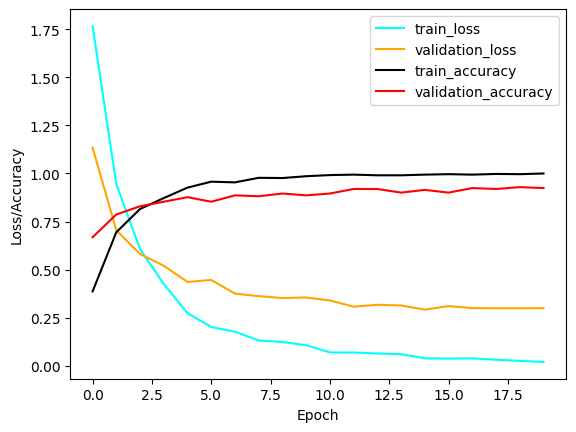

C:\Users\Ehtishaam\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
plt.plot(history.history['loss'], label='train_loss', color = 'Cyan')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'Orange')
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'black')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color = 'red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

# model_save_path = 'E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_2.h5'
model_save_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\skintone_recog1.h5'
model.save(model_save_path)

In [18]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

7/7 [==============================] - 4s 412ms/step
Classification Report:
              precision    recall  f1-score   support

       MST 1       0.94      0.94      0.94        35
       MST 2       0.90      1.00      0.95        28
       MST 3       1.00      0.80      0.89        10
       MST 4       0.92      0.97      0.94        34
       MST 5       0.92      0.80      0.86        15
       MST 6       0.86      0.93      0.89        27
       MST 7       1.00      1.00      1.00         9
       MST 8       0.86      0.71      0.77        17
       MST 9       0.94      0.84      0.89        19
      MST 10       0.89      1.00      0.94        17

    accuracy                           0.91       211
   macro avg       0.92      0.90      0.91       211
weighted avg       0.92      0.91      0.91       211

